In [546]:
import glob
import os
from collections import Counter
import nltk
import pandas as pd
import pylangacq
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

# Set pandas display options to avoid truncation
pd.set_option('display.max_rows', 200)

[nltk_data] Downloading package punkt to /Users/maxreuter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/maxreuter/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/maxreuter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [524]:
# Load the corpora into individual readers, plus a combined reader
# Loading may take several seconds

corpora_paths = sorted(glob.glob('data/*.zip'))
corpora_names = [os.path.splitext(os.path.basename(file))[0] for file in corpora_paths]

readers = {name: pylangacq.read_chat(path) for name, path in zip(corpora_names, corpora_paths)}
readers['Combined'] = sum([*readers.values()][1:], [*readers.values()][0])

readers['Combined'].info()

2033 files
961565 utterances
4663136 words
      Utterance Count    Word Count  File Path
--  -----------------  ------------  ----------------------
#1                170           445  Bates/Free20/amy.cha
#2                148           532  Bates/Free20/betty.cha
#3                167           464  Bates/Free20/chuck.cha
#4                 73           309  Bates/Free20/doug.cha
#5                175           681  Bates/Free20/ed.cha
...
(set `verbose` to True for all the files)


In [525]:
# TODO: corpora have different participants, which we may need to account for.
# For example, do we want to include siblings, etc. in corpora that have them?
# For now, let's assume we are just interested in the child and their parent's speech (CHI, MOT, FAT).

for name, reader in readers.items():
    missing = [participant for participant in ['CHI', 'MOT', 'FAT'] if participant not in reader.participants()]
    if missing:
        print(f"{name} corpus does not have the following participants: {', '.join(missing)}.")


Garvey corpus does not have the following participants: MOT, FAT.


In [526]:
# Initialize variables for storing details per corpora

corpora_statistics     = {name: pd.DataFrame() for name in readers}
corpora_pos_counters   = {name: {}             for name in readers}
corpora_ngram_counters = {name: {}             for name in readers}

def apply_extraction(op, corpora_statistics):
    for name, df in corpora_statistics.items():
        op(df, readers[name], corpora_pos_counters[name], corpora_ngram_counters[name])
    display(corpora_statistics['Combined'])

In [527]:
def get_average_age_months(df, reader, pos_counter, ngram_counter):
    ages = list(filter(None, reader.ages(months=True)))
    df['avg_age_mo'] = [round(sum(ages) / len(ages), 2)]

apply_extraction(get_average_age_months, corpora_statistics)

,avg_age_mo
0,55.79


In [528]:
# Get word count statistics for children and parents, including raw and preprocessed word counts

def get_words_by_pos(word_frequencies, parts_of_speech):
    return Counter({
        word: word_frequencies[word]
        for word, pos in sorted(
            nltk.pos_tag(word_frequencies),
            key=lambda item: word_frequencies[item[0]],
            reverse=True
        ) if pos in parts_of_speech
    })

def get_word_counts(reader, pos_counter, participants):
    def remove_punctuation_and_stopwords(word_frequencies):
        [word_frequencies.pop(word, None)
            for word in
                ['.', '?', '!', '...'] + 
                nltk.corpus.stopwords.words('english')]

        return word_frequencies

    word_frequencies_raw = reader.word_frequencies(participants=participants)
    num_words_raw = sum(word_frequencies_raw.values())
    
    word_frequencies = remove_punctuation_and_stopwords(word_frequencies_raw)
    num_words_pp = sum(word_frequencies.values())
    num_unique_words_pp = len(word_frequencies)

    pos_counter['adjectives'] = get_words_by_pos(word_frequencies, ["JJ", "JJR", "JJS"])
    pos_counter['nouns']      = get_words_by_pos(word_frequencies, ["NN", "NNS", "NNP", "NNPS"])
    pos_counter['verbs']      = get_words_by_pos(word_frequencies, ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"])

    num_adjs  = sum(pos_counter['adjectives'].values())
    num_nouns = sum(pos_counter['nouns'     ].values())
    num_verbs = sum(pos_counter['verbs'     ].values())

    word_counts_df = pd.DataFrame({
        'words_raw'      : [num_words_raw],
        'words_pp'       : [num_words_pp],
        'unique_words_pp': [num_unique_words_pp],
        'adjs'           : [num_adjs],
        'nouns'          : [num_nouns],
        'verbs'          : [num_verbs]
    })

    return word_counts_df

def get_word_count_statistics(df, reader, pos_counter, ngram_counter):
    word_count_statistics = pd.concat([
        get_word_counts(reader, pos_counter, ['CHI']).add_suffix('_chi'),
        get_word_counts(reader, pos_counter, ['MOT', 'FAT']).add_suffix('_par')
    ], axis=1)

    for col in word_count_statistics.columns:
        df[col] = word_count_statistics[col]

apply_extraction(get_word_count_statistics, corpora_statistics)

,avg_age_mo,words_raw_chi,words_pp_chi,unique_words_pp_chi,adjs_chi,nouns_chi,verbs_chi,words_raw_par,words_pp_par,unique_words_pp_par,adjs_par,nouns_par,verbs_par
0,55.79,1270881,544668,12786,71706,235596,115431,1949811,821947,16778,133907,351029,193056


In [529]:
# Print common nouns

corpora_pos_counters['Combined']['nouns']

Counter({'yeah': 11881,
         'gonna': 9456,
         'get': 7427,
         'look': 6716,
         "what's": 6361,
         'wanna': 5327,
         'baby': 4358,
         'Chi': 3999,
         "I'm": 3619,
         "he's": 3120,
         'cname': 3107,
         "let's": 2966,
         "there's": 2812,
         'take': 2769,
         'need': 2588,
         'yes': 2490,
         'something': 2384,
         'mhm': 2329,
         "I'll": 2322,
         'sit': 2299,
         'time': 2208,
         'thank': 2102,
         '/.': 2068,
         'hafta': 2046,
         'let': 1935,
         'job': 1933,
         'please': 1891,
         'ate': 1886,
         'help': 1875,
         'way': 1850,
         'food': 1835,
         "they're": 1780,
         "where's": 1697,
         'kind': 1601,
         'juice': 1532,
         'mm': 1495,
         'gotta': 1418,
         'school': 1397,
         'house': 1369,
         'egg': 1362,
         'watch': 1355,
         'water': 1353,
         'today':

In [530]:
# Print common verbs

corpora_pos_counters['Combined']['verbs']

Counter({'go': 11105,
         'see': 8401,
         'put': 8307,
         'know': 7815,
         'want': 7243,
         'think': 6361,
         'eat': 4899,
         'come': 4667,
         'huh': 4019,
         'got': 3865,
         'said': 3503,
         'say': 3380,
         'going': 3068,
         'make': 3013,
         'play': 2321,
         'tell': 2165,
         'give': 2154,
         'remember': 1982,
         'hm': 1899,
         'try': 1859,
         'mommy': 1755,
         "can't": 1688,
         'turn': 1499,
         'goes': 1452,
         'done': 1449,
         'find': 1381,
         'wait': 1351,
         'looks': 1326,
         'went': 1324,
         'bubbles': 1320,
         'read': 1309,
         'drink': 1268,
         'honey': 1198,
         'called': 1125,
         'bear': 1115,
         'plate': 1111,
         'came': 1078,
         'eating': 1062,
         'blow': 1049,
         'getting': 1030,
         'dog': 942,
         'hear': 852,
         'cat': 809,
    

In [531]:
# Print common adjectives

corpora_pos_counters['Combined']['adjectives']

Counter({'okay': 14968,
         'oh': 9242,
         'good': 6844,
         'right': 6730,
         'little': 4445,
         'alright': 3092,
         'big': 2513,
         'hungry': 2117,
         'uhhuh': 2017,
         'nice': 1840,
         'ready': 1339,
         'much': 1313,
         'caterpillar': 1305,
         'table': 1296,
         'sure': 1210,
         "we're": 1191,
         'hot': 1092,
         "we'll": 1044,
         'mouth': 1042,
         'next': 1038,
         'many': 1034,
         'open': 1020,
         'green': 1011,
         'red': 1001,
         'blue': 896,
         'uhoh': 828,
         'stuff': 821,
         'boy': 793,
         'nose': 790,
         'last': 789,
         'write': 787,
         'mean': 773,
         'danny': 761,
         'keep': 732,
         'elephant': 698,
         'finish': 692,
         'ball': 646,
         'feed': 642,
         'enough': 642,
         'small': 640,
         'top': 625,
         'clean': 614,
         'fit': 610,
  

In [532]:
# Get n-grams (exclude punctuation)

def get_ngrams(df, reader, pos_counter, ngram_counter):
    filter_punctuation = lambda ngram: all([word not in ['.', '?', '!', '...'] for word in ngram])

    ngram_counter['bigrams'  ] = {ngram: count for ngram, count in reader.word_ngrams(participants='CHI', n=2).items() if filter_punctuation(ngram)}
    ngram_counter['trigrams' ] = {ngram: count for ngram, count in reader.word_ngrams(participants='CHI', n=3).items() if filter_punctuation(ngram)}
    ngram_counter['quadgrams'] = {ngram: count for ngram, count in reader.word_ngrams(participants='CHI', n=4).items() if filter_punctuation(ngram)}

apply_extraction(get_ngrams, corpora_statistics)

,avg_age_mo,words_raw_chi,words_pp_chi,unique_words_pp_chi,adjs_chi,nouns_chi,verbs_chi,words_raw_par,words_pp_par,unique_words_pp_par,adjs_par,nouns_par,verbs_par
0,55.79,1270881,544668,12786,71706,235596,115431,1949811,821947,16778,133907,351029,193056


In [533]:
# Display common bigrams

corpora_ngram_counters['Combined']['bigrams']

{('little', 'girl'): 40,
 ('that', 'baby'): 46,
 ('ball', 'oh'): 1,
 ('where', 'ball'): 12,
 ('right', 'in'): 110,
 ('in', 'there'): 1296,
 ('out', 'ball'): 1,
 ('ball', 'huh'): 2,
 ('ah', 'ah'): 197,
 ('oh', 'ball'): 1,
 ('ball', 'go'): 5,
 ('ball', 'ball'): 2,
 ("what's", 'that'): 526,
 ('good', 'Mommy'): 3,
 ('no', 'Mommy'): 8,
 ('uhhuh', 'in'): 1,
 ('see', 'ya'): 6,
 ('my', 'chicken'): 17,
 ('too', 'big'): 108,
 ('little', 'chair'): 5,
 ('throw', 'them'): 11,
 ('them', 'in'): 126,
 ('too', 'high'): 7,
 ('it', 'goes'): 257,
 ('goes', 'in'): 119,
 ('right', 'here'): 1182,
 ('I', "can't"): 922,
 ("can't", 'open'): 33,
 ('no', 'I'): 570,
 ('where', 'people'): 2,
 ('people', 'go'): 13,
 ('daddy', 'daddy'): 11,
 ('another', 'baby'): 24,
 ('he', 'been'): 5,
 ('been', 'asleep'): 1,
 ('this', 'one'): 1930,
 ('one', 'shut'): 1,
 ('come', 'out'): 130,
 ('out', 'there'): 65,
 ('there', 'car'): 1,
 ('open', 'the'): 95,
 ('the', 'door'): 240,
 ('where', 'do'): 38,
 ('another', 'chair'): 14,
 ('c

In [534]:
# Display common trigrams

corpora_ngram_counters['Combined']['trigrams']

{('right', 'in', 'there'): 25,
 ('out', 'ball', 'huh'): 1,
 ('oh', 'ball', 'go'): 1,
 ('where', 'ball', 'go'): 1,
 ('uhhuh', 'in', 'there'): 1,
 ('throw', 'them', 'in'): 4,
 ('it', 'goes', 'in'): 29,
 ('goes', 'in', 'there'): 30,
 ('I', "can't", 'open'): 24,
 ('no', 'I', "can't"): 28,
 ('where', 'people', 'go'): 2,
 ('he', 'been', 'asleep'): 1,
 ('this', 'one', 'shut'): 1,
 ('come', 'out', 'there'): 2,
 ('out', 'there', 'car'): 1,
 ('open', 'the', 'door'): 47,
 ('chair', 'there', 'is'): 1,
 ('I', "don't", 'know'): 1661,
 ('in', 'high', 'in'): 1,
 ('the', 'other', 'one'): 141,
 ('ah', 'doggie', 'get'): 1,
 ('doggie', 'get', 'in'): 1,
 ('no', 'no', 'no'): 147,
 ('in', 'a', 'ride'): 1,
 ("where's", 'the', 'ball'): 9,
 ("where's", 'the', 'car'): 2,
 ('this', 'a', 'ball'): 1,
 ('where', 'the', 'ball'): 4,
 ('want', 'the', 'ball'): 3,
 ('a', 'mommy', 'go'): 1,
 ('mommy', 'go', 'to'): 2,
 ('this', 'seen', 'ball'): 1,
 ('there', 'want', 'a'): 1,
 ('want', 'a', 'ball'): 2,
 ('a', 'a', 'ball'): 

In [535]:
# Display common quadgrams

corpora_ngram_counters['Combined']['quadgrams']

{('it', 'goes', 'in', 'there'): 7,
 ('come', 'out', 'there', 'car'): 1,
 ('ah', 'doggie', 'get', 'in'): 1,
 ('a', 'mommy', 'go', 'to'): 1,
 ('there', 'want', 'a', 'ball'): 1,
 ('up', 'up', 'up', 'up'): 3,
 ('I', 'need', 'a', 'ride'): 1,
 ('take', 'it', 'all', 'out'): 3,
 ('this', 'go', 'in', 'here'): 4,
 ('it', 'went', 'in', 'here'): 2,
 ('where', 'is', 'the', 'doggie'): 1,
 ("where's", 'the', 'little', 'baby'): 1,
 ('what', 'does', 'baby', 'say'): 1,
 ('what', 'does', 'doggie', 'say'): 1,
 ('what', 'does', 'doggie', 'says'): 1,
 ('this', 'is', 'hard', 'work'): 2,
 ("where's", 'other', 'over', 'there'): 1,
 ('puts', 'man', 'at', 'bottom'): 1,
 ('man', 'at', 'bottom', 'of'): 1,
 ('at', 'bottom', 'of', 'ladder'): 1,
 ('bottom', 'of', 'ladder', 'and'): 1,
 ('of', 'ladder', 'and', 'then'): 1,
 ('ladder', 'and', 'then', 'walks'): 1,
 ('and', 'then', 'walks', 'him'): 1,
 ('then', 'walks', 'him', 'up'): 1,
 ('walks', 'him', 'up', 'one'): 1,
 ('him', 'up', 'one', 'step'): 1,
 ('up', 'one', 'st

In [536]:
# Get word frequency comparisons between children and parents
# This is expected to raise RuntimeWarnings for divisions-by-zero since the Garvey corpus has no parent participants.

# Note/hypothesis:
# Child saying more nouns and fewer verbs and adjectives (relative to themselves) than parents
#   --> Parent is driving the play narrative (e.g. "the doll is going to dinner"),
#       while child is reacting, especially to prompts by parent,
#       (e.g. "what is the doll eating? [verb]" --> "bread" [noun])
# Also, saying fewer adjectives may indicate that the child is less descriptive than an adult

def get_parent_child_word_frequencies_comparisons(df, reader, pos_counter, ngram_counter):
    df['pct_nouns_chi' ] = round(df['nouns_chi'].sum() / df['words_pp_chi'].sum(), 2)
    df['pct_verbs_chi' ] = round(df['verbs_chi'].sum() / df['words_pp_chi'].sum(), 2)
    df['pct_adjs_chi'  ] = round(df['adjs_chi' ].sum() / df['words_pp_chi'].sum(), 2)

    df['pct_nouns_par' ] = round(df['nouns_par'].sum() / df['words_pp_par'].sum(), 2)
    df['pct_verbs_par' ] = round(df['verbs_par'].sum() / df['words_pp_par'].sum(), 2)
    df['pct_adjs_par'  ] = round(df['adjs_par' ].sum() / df['words_pp_par'].sum(), 2)

    df['pct_spoken_chi']       = round(df['words_pp_chi'].sum() / (df['words_pp_chi'].sum() + df['words_pp_par'].sum()), 2)
    df['rat_chi_nouns_to_par'] = round(df['pct_nouns_chi'] / df['pct_nouns_par'], 2)
    df['rat_chi_verbs_to_par'] = round(df['pct_verbs_chi'] / df['pct_verbs_par'], 2)
    df['rat_chi_adjs_to_par' ] = round(df['pct_adjs_chi' ] / df['pct_adjs_par' ], 2)

apply_extraction(get_parent_child_word_frequencies_comparisons, corpora_statistics)

/var/folders/cx/nbz8tq511x96rngcrp3c35zm0000gn/T/ipykernel_90582/1281058627.py:16: RuntimeWarning: invalid value encountered in scalar divide
  df['pct_nouns_par' ] = round(df['nouns_par'].sum() / df['words_pp_par'].sum(), 2)
/var/folders/cx/nbz8tq511x96rngcrp3c35zm0000gn/T/ipykernel_90582/1281058627.py:17: RuntimeWarning: invalid value encountered in scalar divide
  df['pct_verbs_par' ] = round(df['verbs_par'].sum() / df['words_pp_par'].sum(), 2)
/var/folders/cx/nbz8tq511x96rngcrp3c35zm0000gn/T/ipykernel_90582/1281058627.py:18: RuntimeWarning: invalid value encountered in scalar divide
  df['pct_adjs_par'  ] = round(df['adjs_par' ].sum() / df['words_pp_par'].sum(), 2)


,avg_age_mo,words_raw_chi,words_pp_chi,unique_words_pp_chi,adjs_chi,nouns_chi,verbs_chi,words_raw_par,words_pp_par,unique_words_pp_par,...,pct_nouns_chi,pct_verbs_chi,pct_adjs_chi,pct_nouns_par,pct_verbs_par,pct_adjs_par,pct_spoken_chi,rat_chi_nouns_to_par,rat_chi_verbs_to_par,rat_chi_adjs_to_par
0,55.79,1270881,544668,12786,71706,235596,115431,1949811,821947,16778,...,0.43,0.21,0.13,0.43,0.23,0.16,0.4,1.0,0.91,0.81


In [537]:
# Display statistics on the amount of child words and relative size of each corpora

num_child_words = corpora_statistics['Combined']['words_pp_chi'].sum()
num_child_words_unique = corpora_statistics['Combined']['unique_words_pp_chi'].sum()
spoken_wpm = 130

print(f"Total number of child words:            {num_child_words} (~{num_child_words / (spoken_wpm*60):.1f} spoken hours)")
print(f"Total number of unique child words:     {num_child_words_unique}")
print(f"Ratio of unique words (word diversity): {round(num_child_words_unique / num_child_words, 2)} (also see Zipf's law)")
print()

print('Corpora sizes (relative, by child word count):')
for name in corpora_names:
    print(f"    {name}: {corpora_statistics[name]['words_pp_chi'].sum() / num_child_words * 100:.1f}%")

Total number of child words:            544668 (~69.8 spoken hours)
Total number of unique child words:     12786
Ratio of unique words (word diversity): 0.02 (also see Zipf's law)

Corpora sizes (relative, by child word count):
    Bates: 0.8%
    Champaign: 29.6%
    Garvey: 2.5%
    HSLLD: 35.1%
    Hall: 32.0%


In [538]:
# Display statistics on the average ages, word presence, and part-of-speech usage of children in each corpora
# "Child word presence" refers to the percentage of words spoken by the child (i.e. not parents, siblings, etc.)

print('Corpora child ages, word presence (compared to other participants), and part-of-speech usages:')
for name in corpora_names:
    stt = corpora_statistics[name]
    print(f"    {name}:")
    print(f"                  Age (avg): {stt['avg_age_mo'].values[0]} months")
    print(f"        Child word presence: {stt['pct_spoken_chi'].values[0] * 100:.1f}%")
    print(f"              Nouns (child): {stt['pct_nouns_chi'].values[0] * 100:.0f}%")
    print(f"              Verbs (child): {stt['pct_verbs_chi'].values[0] * 100:.0f}%")
    print(f"               Adj. (child): {stt['pct_adjs_chi' ].values[0] * 100:.0f}%")
    print()

Corpora child ages, word presence (compared to other participants), and part-of-speech usages:
    Bates:
                  Age (avg): 25.78 months
        Child word presence: 22.0%
              Nouns (child): 51%
              Verbs (child): 19%
               Adj. (child): 16%

    Champaign:
                  Age (avg): 28.52 months
        Child word presence: 37.0%
              Nouns (child): 45%
              Verbs (child): 20%
               Adj. (child): 14%

    Garvey:
                  Age (avg): 50.49 months
        Child word presence: 100.0%
              Nouns (child): 43%
              Verbs (child): 27%
               Adj. (child): 13%

    HSLLD:
                  Age (avg): 69.73 months
        Child word presence: 33.0%
              Nouns (child): 42%
              Verbs (child): 19%
               Adj. (child): 15%

    Hall:
                  Age (avg): 56.92 months
        Child word presence: 56.0%
              Nouns (child): 41%
              Verbs (child)

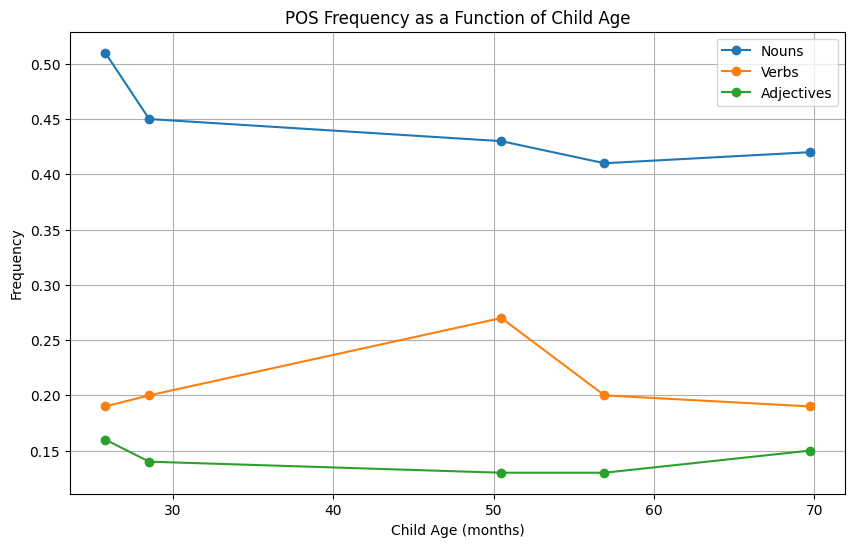

In [549]:
# Plot the frequency of nouns, verbs, and adjectives as a function of child age
# This is a dummy statistic for now - it should be compared with that of parents, etc. to see if it's meaningful

pos_freq_as_child_ages = {
    float(corpora_statistics[name]['avg_age_mo'].values[0]): {
        'nouns': float(corpora_statistics[name]['pct_nouns_chi'].values[0]),
        'verbs': float(corpora_statistics[name]['pct_verbs_chi'].values[0]),
        'adjs' : float(corpora_statistics[name]['pct_adjs_chi' ].values[0])
    } for name in corpora_names
}
pos_freq_as_child_ages = dict(sorted(pos_freq_as_child_ages.items()))

ages  = list(pos_freq_as_child_ages.keys())
nouns = [data['nouns'] for data in pos_freq_as_child_ages.values()]
verbs = [data['verbs'] for data in pos_freq_as_child_ages.values()]
adjs  = [data['adjs' ] for data in pos_freq_as_child_ages.values()]

plt.figure(figsize=(10, 6))
plt.plot(ages, nouns, marker='o', label='Nouns')
plt.plot(ages, verbs, marker='o', label='Verbs')
plt.plot(ages, adjs,  marker='o', label='Adjectives')

plt.xlabel('Child Age (months)')
plt.ylabel('Frequency')
plt.title('POS Frequency as a Function of Child Age')
plt.legend()
plt.grid(True)
plt.show()